In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

### Reading data

In [11]:
biyashee_colony_cnts = pd.read_csv('data/Bishayee Colony Counts 10.27.97-3.8.01.csv', skiprows=2)
biyashee_coulter_cnts = pd.read_csv('data/Bishayee Coulter Counts.10.20.97-7.16.01.csv', skiprows=1)
other_colony_cnts = pd.read_csv('data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.csv', skiprows=1)
other_coulter_cnts = pd.read_csv('data/Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.csv', skiprows=1)
outside_coulter_cnts1 = pd.read_csv('data/Outside Lab 1.Coulter Counts.6.7.91-4.9.99.csv')
outside_coulter_cnts2 = pd.read_csv('data/Outside Lab 2.Coulter Counts.6.6.08-7.7.08.csv', skiprows=1)
outside_colony_cnts =  pd.read_csv('data/Outside Lab 3.Colony Counts.2.4.10-5.21.12.csv', skiprows=1)

#### Filling missing headers, dates, experiment numbers

In [12]:
# standardizing column names for dataframes
biyashee_colony_cnts.columns = ['Isotope', 'Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
biyashee_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
other_colony_cnts.columns = ['Bates', 'Date', 'Inv', 'c1', 'c2', 'c3', 'avg']
other_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg', 'Inv']
outside_coulter_cnts1.columns = ['Experiment', 'c1', 'c2', 'c3', 'avg', 'Date']
outside_coulter_cnts2.columns = ['Date', 'c1', 'c2', 'c3', 'avg']
outside_colony_cnts.columns = ['Date', 'c1', 'c2', 'c3', 'avg']

# converting to numerics
biyashee_colony_cnts['c3'] = pd.to_numeric(biyashee_colony_cnts['c3'], errors = 'coerce')
other_colony_cnts['c3'] = pd.to_numeric(other_colony_cnts['c3'], errors = 'coerce')

# filling in experiment and date info
for i in range(len(outside_coulter_cnts1)):
    if outside_coulter_cnts1['Experiment'].isnull()[i]:
        outside_coulter_cnts1.loc[i, 'Experiment'] = outside_coulter_cnts1['Experiment'][i-1]
    if outside_coulter_cnts1['Date'].isnull()[i]:
        outside_coulter_cnts1.loc[i, 'Date'] = outside_coulter_cnts1['Date'][i-1]

# filling in date info for outside_coulter_cnts2
for i in range(len(outside_coulter_cnts2)):
    if outside_coulter_cnts2['Date'].isnull()[i]:
        outside_coulter_cnts2.loc[i, 'Date'] = outside_coulter_cnts2['Date'][i-1]
        
# filling in date info for outside_colony counts
for i in range(len(outside_colony_cnts)):
    if outside_colony_cnts['Date'].isnull()[i]:
        outside_colony_cnts.loc[i, 'Date'] = outside_colony_cnts['Date'][i-1]

### Terminal digits analysis
#### Testing the assumptions: Is the terminal digit of a Poisson variable uniform?

<IPython.core.display.Javascript object>


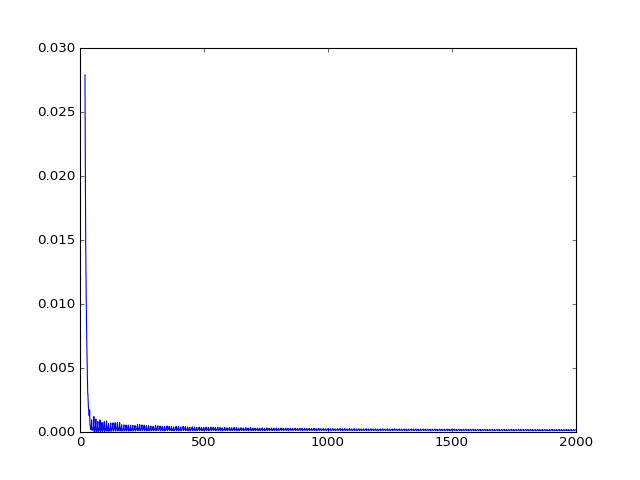

In [13]:
def termd_poisson_tv(mu):
    '''computes the total variation distance of the terminal digit distribution against uniform'''
    # Computes the probability mass, tail probability disregarded
    num_comp = np.ceil(stats.poisson.ppf(0.999, mu) / 10) * 10
    prob = stats.poisson.pmf(np.arange(num_comp), mu)
    # Normalization by 1-norm
    prob = prob / np.linalg.norm(prob, 1)
    # Reshaping prob into 10 columns so each row can be added
    prob = np.reshape(prob, (-1, 10))
    return np.linalg.norm(prob.sum(axis = 0) - np.ones(10) / 10, 1)

v_termd_poisson_tv = np.vectorize(termd_poisson_tv)
# Range of mu we are plotting
x = np.arange(20, 2000)
plt.plot(x, v_termd_poisson_tv(x))

The total variation distance decreases and thus this assumption that the terminal digit distributes uniformly seems reasonable.

#### Replication

In [14]:
def termd_count(df):
    '''counts the terminal digit in dataframe df. df must have c1, c2, c3'''
    c1_termd = df['c1'].mod(10).value_counts().sort_index()
    c2_termd = df['c2'].mod(10).value_counts().sort_index()
    c3_termd = df['c3'].mod(10).value_counts().sort_index()
    return list(c1_termd + c2_termd + c3_termd)

# corresponds to table 3 in Pitt and Hill
table3 = pd.DataFrame([termd_count(biyashee_colony_cnts),
                       termd_count(biyashee_coulter_cnts),
                       termd_count(other_colony_cnts),
                       termd_count(other_coulter_cnts),
                       termd_count(outside_coulter_cnts1),
                       termd_count(outside_coulter_cnts2),
                       termd_count(outside_colony_cnts)],
                      columns = range(10))
table3['index'] = pd.Series(['biyashee_colony_cnts', 'biyashee_coulter_cnts',
                             'other_colony_cnts', 'other_coulter_cnts',
                             'outside_coulter_cnts1', 'outside_coulter_cnts2',
                             'outside_colony_cnts'],
                            index = table3.index)
table3.set_index('index', inplace = True)
table3.index.name = None
table3['total'] = table3.sum(axis = 1)
table3['chi-square'] = 0
for i in range(10):
    table3['chi-square'] += (table3[i] - table3['total'] / 10) ** 2 / (table3['total'] / 10)
table3['p'] = stats.chisqprob(table3['chi-square'], 9)
print(table3)

                         0    1    2    3    4    5    6    7    8    9  \
biyashee_colony_cnts   564  324  463  313  290  478  336  408  383  526   
biyashee_coulter_cnts  475  613  736  416  335  732  363  425  372  718   
other_colony_cnts      191  181  195  179  184  175  178  185  185  181   
other_coulter_cnts     261  311  295  259  318  290  298  283  331  296   
outside_coulter_cnts1   28   34   29   25   27   36   44   33   26   33   
outside_coulter_cnts2   34   38   45   35   32   42   31   35   35   33   
outside_colony_cnts     21    9   15   16   19   19    9   19   11   12   

                       total  chi-square             p  
biyashee_colony_cnts    4085  200.725826  2.333780e-38  
biyashee_coulter_cnts   5185  466.874638  7.062273e-95  
other_colony_cnts       1834    1.790622  9.943625e-01  
other_coulter_cnts      2942   15.994562  6.699524e-02  
outside_coulter_cnts1    315    9.476190  3.945273e-01  
outside_coulter_cnts2    360    4.944444  8.391240e-01  


Although the `total` column in the paper does not add up correctly, fixing it did not change the p-values much

#### Alternative analysis: Permutation test